Goal is to create an algorithm that takes a D8 grid and a number of samples and returns the localities of the sample sites that best subdivide the area.

## Generate example landscape

/home/alex/anaconda3/envs/working/bin/python


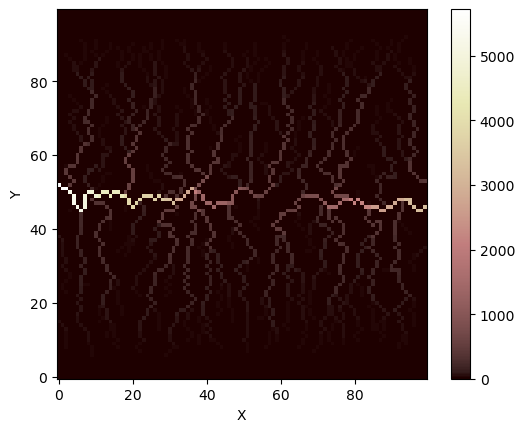

<Figure size 640x480 with 0 Axes>

In [2]:
import sys

print(sys.executable)

import landlab
import matplotlib.pyplot as plt
import numpy as np
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, SinkFillerBarnes

# nx = 100
# ny = 100
# mg = RasterModelGrid(shape=(nx, ny))
# z = np.zeros(mg.shape)
# for i in range(nx):
#     for j in range(ny):
#         z[i, j] = (i - (nx / 2)) ** 2 + (100 * np.random.rand())
# mg.add_field("topographic__elevation", z)
# mg.set_closed_boundaries_at_grid_edges(False, True, False, True)

# sb = SinkFillerBarnes(mg)
# sb.run_one_step()

# mg.save("topo.asc",names='topographic__elevation')


ascii_data = landlab.io.esri_ascii.read_esri_ascii("topo.asc")
mg = ascii_data[0]
mg.add_field("topographic__elevation", ascii_data[1])
frr = FlowAccumulator(mg, flow_director="FlowDirectorD8")
frr.run_one_step()
landlab.plot.imshow_grid(mg, "drainage_area", output=True)

## Autosampler algorithm


TODO: 

1. Remove all landlab dependencies
2. 

In [3]:
def get_sample_nodes(model_grid, num_samps, increment=0.01):
    print("Setting up")

    # Node array containing downstream-to-upstream ordered list of node
    ordered_nodes = model_grid.at_node["flow__upstream_node_order"]
    total_area = len(ordered_nodes)
    A_per_samp = total_area / num_samps

    node_area_dict = {}
    for node in ordered_nodes:
        node_area_dict[node] = landlab.utils.get_watershed_nodes(model_grid, node)

    samps_allocated = 0
    iterations = 0
    print("Starting iterations")
    while samps_allocated < num_samps:

        V = []  # visited nodes
        uV = ordered_nodes.tolist()  # unvisited otes
        sample_nodes = {}
        samps_allocated = 0

        print("Trying with target area = ", A_per_samp)
        for i in np.arange(len(ordered_nodes) - 1, -1, -1):
            # Iterate from upstream to downstream
            node = ordered_nodes[i]  # Node in network
            all_upst_nodes = node_area_dict[node]  # Get all the upstream nodes
            unvisited_upst_nodes = all_upst_nodes[
                np.isin(all_upst_nodes, uV)
            ]  # Identify those which are 'new'
            if len(unvisited_upst_nodes) > A_per_samp:
                print("Found a sample locality:", node)
                sample_nodes[node] = unvisited_upst_nodes  # Add node to list
                for x in unvisited_upst_nodes:  # Remove added nodes to unvisited list
                    uV.remove(x)
                samps_allocated += 1
                if samps_allocated == num_samps:
                    break
        iterations += 1
        print("# Finished iteration", iterations, "#")
        if samps_allocated < num_samps:
            print("Only allocated:", samps_allocated, "of", num_samps)
            print("Trying again with smaller target area...")
            print("___________________________")
        else:
            print("All samples allocated")
            print("Finishing...")
        A_per_samp = A_per_samp * (
            1 - increment
        )  # initial target number of nodes per samp
    return sample_nodes

In [4]:
sample_nodes_catchments = get_sample_nodes(mg, 5, increment=0.1)

Setting up
Starting iterations
Trying with target area =  2000.0
Found a sample locality: 5037
Found a sample locality: 4917
Found a sample locality: 4879
# Finished iteration 1 #
Only allocated: 3 of 5
Trying again with smaller target area...
___________________________
Trying with target area =  1800.0
Found a sample locality: 5037
Found a sample locality: 4719
Found a sample locality: 5102
Found a sample locality: 4879
# Finished iteration 2 #
Only allocated: 4 of 5
Trying again with smaller target area...
___________________________
Trying with target area =  1620.0
Found a sample locality: 5037
Found a sample locality: 4822
Found a sample locality: 4704
Found a sample locality: 4879
# Finished iteration 3 #
Only allocated: 4 of 5
Trying again with smaller target area...
___________________________
Trying with target area =  1458.0
Found a sample locality: 5037
Found a sample locality: 4828
Found a sample locality: 4506
Found a sample locality: 4879
# Finished iteration 4 #
Only al

In [ ]:
def save_results(locs,areas):
    np.savetxt("sample_sites.csv",X=locs, delimiter=',', header="Area ID, x, y",comments="")
    _ = mg.add_field("area_IDs",node_map)
    mg.save("area_IDs.asc",names='area_IDs')

In [28]:
def process_output_dict(node_catchment_dict,model_grid):
    out_area = np.zeros(model_grid.shape).flatten() - 999
    N=1
    Ns,xs,ys = [],[],[]
    for node,upst_nodes in node_catchment_dict.items():
        x,y = np.unravel_index(node,model_grid.shape)
        Ns+=[N]
        xs+=[x]
        ys+=[y]
        out_area[upst_nodes]=N
        N+=1
    out_area=out_area.reshape(model_grid.shape)
    return(np.array([Ns,xs,ys]).T,out_area)

localities,node_map = process_output_dict(sample_nodes_catchments,mg)


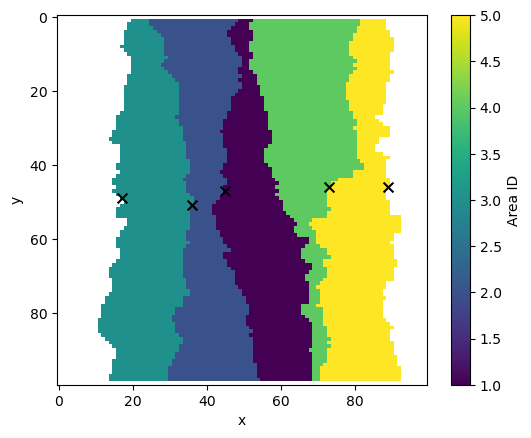

In [49]:



viz_results(localities,node_map)
